In [76]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Подготовка данных

In [204]:
file = pd.read_csv("data/diabetes-dataset.csv")
file.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [190]:
# Разбиваем выборку на тренировочный и тестовый наборы
seed = 256
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# RandomForest

C:\Users\Самикаевы\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


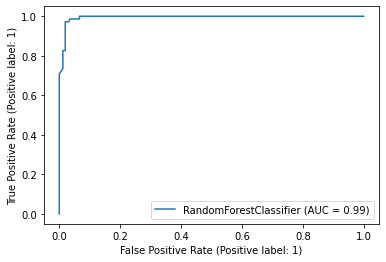

In [213]:
from sklearn.ensemble import RandomForestClassifier

# задаем гиперпараметры
parameters = {'n_estimators': [10, 50, 100], 
              'criterion':['gini', 'entropy'], 
              'max_depth': [2, 4, 6, None]}

# создаем объект GridSearch
gridSearch_RFС = GridSearchCV(RandomForestClassifier(), parameters, scoring='accuracy')

# обучаем модели
gridSearch_RFС.fit(x_train, y_train)

 # извлекаем лучшую модель
best_RFC = gridSearch_RFС.best_estimator_

# ROC-кривая
plot_roc_curve(best_RFC, x_test, y_test)

C:\Users\E394~1\AppData\Local\Temp/ipykernel_4236/1492604361.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roc = np.array(roc)


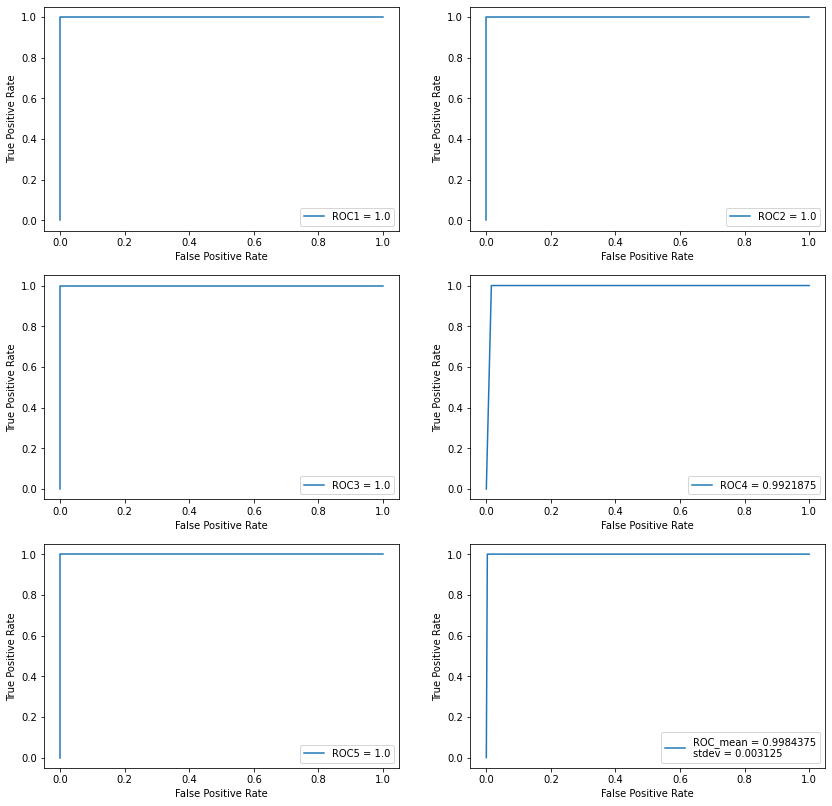

In [214]:
# K-блочная стратифицированная проверка 
from sklearn.model_selection import StratifiedKFold

# разделяем датасет на 5 кросс-сетов
skf = StratifiedKFold(n_splits=5)

roc = []
feature_importances_RFCs = []

# данные
X = file.loc[ : , 'Pregnancies':'Age'].values
y = file['Outcome'].values

for train_index, test_index in skf.split(X, y):
    # получаем обучающие и тестовые наборы
    x_tr, y_tr = X[train_index], y[train_index]
    x_ts, y_ts = X[test_index], y[test_index]
    
    # создаем модель на основе наилучших параметров
    randomForest = RandomForestClassifier(**gridSearch_RFС.best_params_)
    # обучаем модель
    randomForest.fit(x_tr, y_tr)
    
    # добавляем важные признаки в список
    feature_importances_RFCs.append(randomForest.feature_importances_)

    # рассчитываем fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, randomForest.predict(x_test))
    # рассчитываем площадь под кривой roc
    roc_score = roc_auc_score(y_test, randomForest.predict(x_test))
    # добавляем все в список
    roc.append([fpr, tpr, roc_score])

roc = np.array(roc)

# создаем объект подложки с заданными размерами
plt.figure(figsize=(14, 14))

# задаем счетик
i = 1
# задаем список всех auc
roc_std = []
for x, y, auc in roc:  # проходимся по всем сетам
    plt.subplot(3, 2, i)
    
    # подпишем оси
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # нарисуем график и создадим легенду
    plt.plot(x, y, label=f'ROC{i} = {auc}')
    plt.legend()
    
    # добавим auc в список
    roc_std.append(auc)
    i += 1

# рассчитаем средние значения
x_mean, y_mean, auc_mean = np.sum(roc, axis=0) / 5

# найдем стандартное отклонение
roc_std = np.std(roc_std)

# построим график roc_mean
plt.subplot(3, 2, i)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(x_mean, y_mean, label=f'ROC_mean = {auc_mean}\nstdev = {roc_std}')
plt.legend()

<BarContainer object of 8 artists>

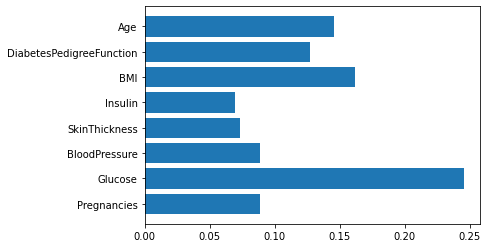

In [215]:
# названия признаков
feature_names_RFC = list(file.columns[ :-1])
# значения важности признаков
feature_importances_RFC = best_RFC.feature_importances_

# визуализация важности признаков
plt.barh(feature_names_RFC, feature_importances_RFC)

<BarContainer object of 8 artists>

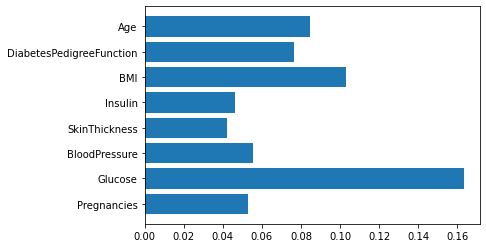

In [216]:
# рассчитаем средние значения важностей признаков для всех моделей
mean_feature_importances_RFC = np.sum(feature_importances_RFCs, axis=0) / len(feature_names_RFC)
# визуализация важности признаков
plt.barh(feature_names_RFC, mean_feature_importances_RFC)

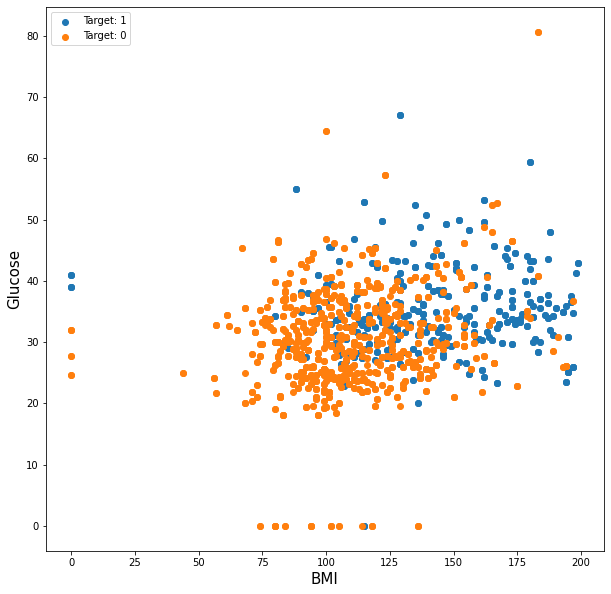

In [217]:
# построим область решений для признаков Glucose и BMI
# данные
glucose = file['Glucose'].values
bmi = file['BMI'].values
outcome = file['Outcome'].values

# создаем два списка с значениями Glucose и BMI для outcome = 1 и для outcome = 0
one = [[], []]
zero = [[], []]
for i, n in enumerate(outcome):
    if n == 1:
        one[0].append(glucose[i])
        one[1].append(bmi[i])
    else:
        zero[0].append(glucose[i])
        zero[1].append(bmi[i])
        
# создаем объект подложки с заданными размерами
plt.figure(figsize=(10, 10))

# подписываем оси
plt.ylabel('Glucose', size=15)
plt.xlabel('BMI', size=15)

# рисуем график для outcome=1
plt.scatter(one[0], one[1], label=f'Target: 1')
plt.legend()

# рисуем график для outcome=0
plt.scatter(zero[0], zero[1], label=f'Target: 0')
plt.legend()

# XGBoost

C:\Users\Самикаевы\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


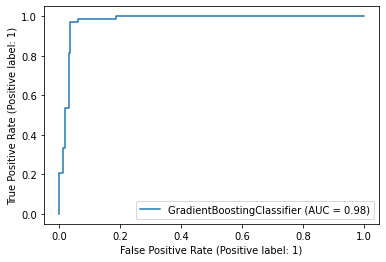

In [200]:
from sklearn.ensemble import GradientBoostingClassifier

# задаем гиперпараметры
parameters = {'loss':['deviance', 'exponential'],
              'n_estimators':[10, 50, 100],
              'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'], 
              'max_depth': [3, 6, 9]}

# создаем объект GridSearch
gridSearch_XGB = GridSearchCV(GradientBoostingClassifier(), parameters, scoring='accuracy')

# отлавливаем предупреждения
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # игнорируем предупреждения
    
    # обучаем модели
    gridSearch_XGB.fit(x_train, y_train)
    
     # извлекаем лучшую модель
    best_XGB = gridSearch_XGB.best_estimator_
    
# ROC-кривая
plot_roc_curve(best_XGB, x_test, y_test)

C:\Users\E394~1\AppData\Local\Temp/ipykernel_4236/4129685117.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roc = np.array(roc)


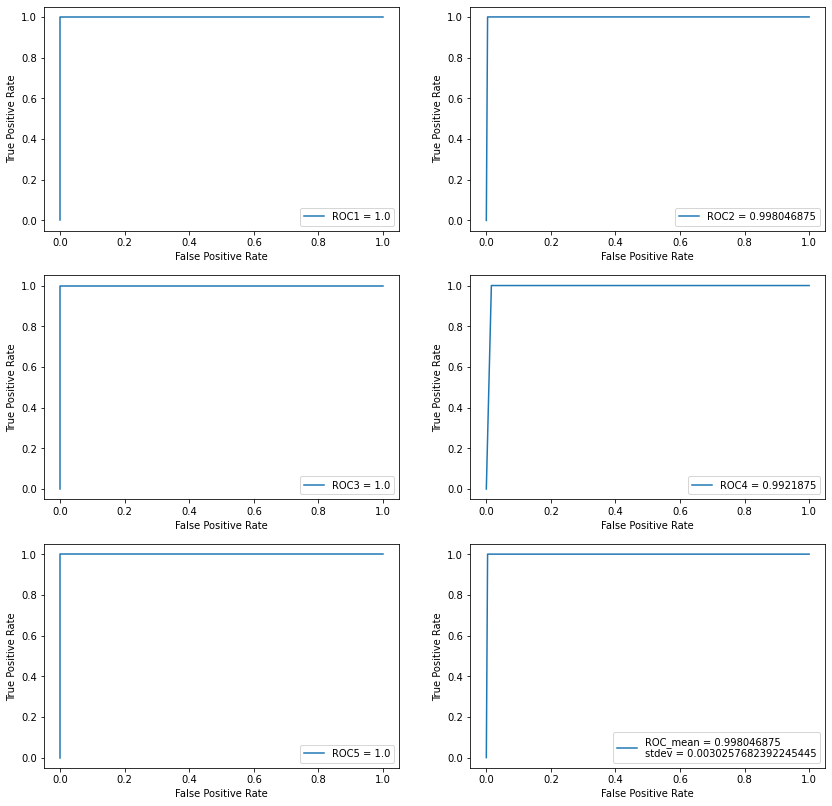

In [201]:
# K-блочная стратифицированная проверка 
from sklearn.model_selection import StratifiedKFold

# разделяем датасет на 5 кросс-сетов
skf = StratifiedKFold(n_splits=5)

roc = []

# данные
X = file.loc[ : , 'Pregnancies':'Age'].values
y = file['Outcome'].values

for train_index, test_index in skf.split(X, y):
    # получаем обучающие и тестовые наборы
    x_tr, y_tr = X[train_index], y[train_index]
    x_ts, y_ts = X[test_index], y[test_index]
    
    # создаем модель на основе наилучших параметров
    xgboost = GradientBoostingClassifier(**gridSearch_XGB.best_params_)
    # обучаем модель
    xgboost.fit(x_tr, y_tr)

    # рассчитываем fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, xgboost.predict(x_test))
    # рассчитываем площадь под кривой roc
    roc_score = roc_auc_score(y_test, xgboost.predict(x_test))
    # добавляем все в список
    roc.append([fpr, tpr, roc_score])

roc = np.array(roc)

# создаем объект подложки с заданными размерами
plt.figure(figsize=(14, 14))

# задаем счетик
i = 1
# задаем список всех auc
roc_std = []
for x, y, auc in roc:  # проходимся по всем сетам
    plt.subplot(3, 2, i)
    
    # подпишем оси
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # нарисуем график и создадим легенду
    plt.plot(x, y, label=f'ROC{i} = {auc}')
    plt.legend()
    
    # добавим auc в список
    roc_std.append(auc)
    i += 1

# рассчитаем средние значения
x_mean, y_mean, auc_mean = np.sum(roc, axis=0) / 5

# найдем стандартное отклонение
roc_std = np.std(roc_std)

# построим график roc_mean
plt.subplot(3, 2, i)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(x_mean, y_mean, label=f'ROC_mean = {auc_mean}\nstdev = {roc_std}')
plt.legend()

# LogisticRegression

C:\Users\Самикаевы\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


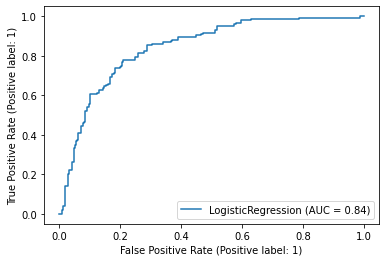

In [202]:
from sklearn.linear_model import LogisticRegression

# задаем гиперпараметры
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 
              'C':[1, 2],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [50, 100, 150]}

# создаем объект GridSearch
gridSearch_LR = GridSearchCV(LogisticRegression(), parameters, scoring='accuracy')

# отлавливаем предупреждения
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # игнорируем предупреждения
    
    # обучаем модель
    gridSearch_LR.fit(x_train, y_train)
    
    # извлекаем лучшую модель
    best_LR = gridSearch_LR.best_estimator_
    
# ROC-кривая
plot_roc_curve(best_LR, x_test, y_test)

C:\Users\E394~1\AppData\Local\Temp/ipykernel_4236/443453028.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roc = np.array(roc)


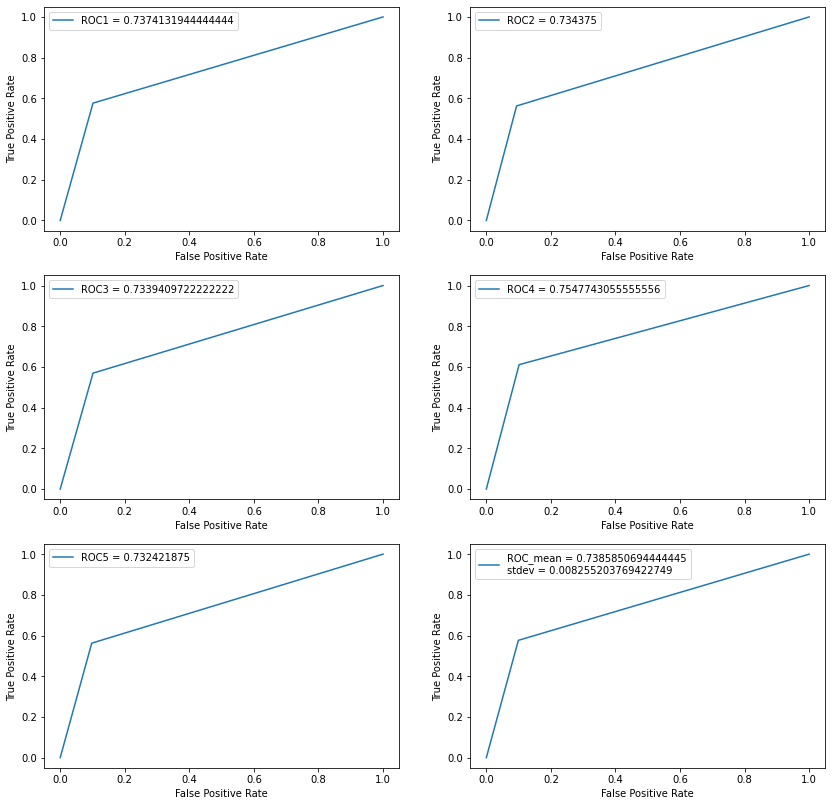

In [218]:
# K-блочная стратифицированная проверка 
from sklearn.model_selection import StratifiedKFold

# разделяем датасет на 5 кросс-сетов
skf = StratifiedKFold(n_splits=5)

roc = []
feature_importances_LRs = []

# данные
X = file.loc[ : , 'Pregnancies':'Age'].values
y = file['Outcome'].values

for train_index, test_index in skf.split(X, y):
    # получаем обучающие и тестовые наборы
    x_tr, y_tr = X[train_index], y[train_index]
    x_ts, y_ts = X[test_index], y[test_index]
    
    # создаем модель на основе наилучших параметров
    logReg = LogisticRegression(**gridSearch_LR.best_params_)
    # обучаем модель
    logReg.fit(x_tr, y_tr)
    
    # добавляем важные признаки в список
    feature_importances_LRs.append(list(logReg.coef_[0]))

    # рассчитываем fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, logReg.predict(x_test))
    # рассчитываем площадь под кривой roc
    roc_score = roc_auc_score(y_test, logReg.predict(x_test))
    # добавляем все в список
    roc.append([fpr, tpr, roc_score])

roc = np.array(roc)

# создаем объект подложки с заданными размерами
plt.figure(figsize=(14, 14))

# задаем счетик
i = 1
# задаем список всех auc
roc_std = []
for x, y, auc in roc:  # проходимся по всем сетам
    plt.subplot(3, 2, i)
    
    # подпишем оси
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # нарисуем график и создадим легенду
    plt.plot(x, y, label=f'ROC{i} = {auc}')
    plt.legend()
    
    # добавим auc в список
    roc_std.append(auc)
    i += 1

# рассчитаем средние значения
x_mean, y_mean, auc_mean = np.sum(roc, axis=0) / 5

# найдем стандартное отклонение
roc_std = np.std(roc_std)

# построим график roc_mean
plt.subplot(3, 2, i)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(x_mean, y_mean, label=f'ROC_mean = {auc_mean}\nstdev = {roc_std}')
plt.legend()

<BarContainer object of 8 artists>

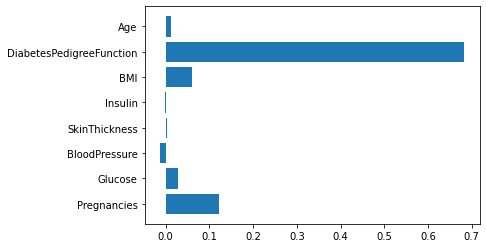

In [219]:
# значения важности признаков
feature_importances_LR = list(best_LR.coef_[0])
# названия признаков
feature_names_LR = list(file.columns[ :-1])

# визуализация важности признаков
plt.barh(feature_names_LR, feature_importances_LR)

<BarContainer object of 8 artists>

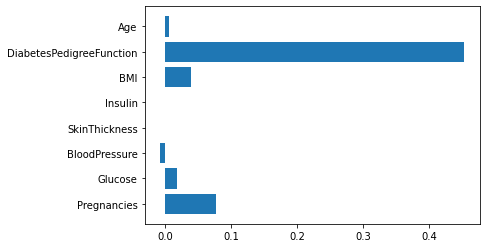

In [220]:
# рассчитаем средние значения важностей признаков для всех моделей
mean_feature_importances_LR = np.sum(feature_importances_LRs, axis=0) / len(feature_names_LR)
# визуализация важности признаков
plt.barh(feature_names_LR, mean_feature_importances_LR)

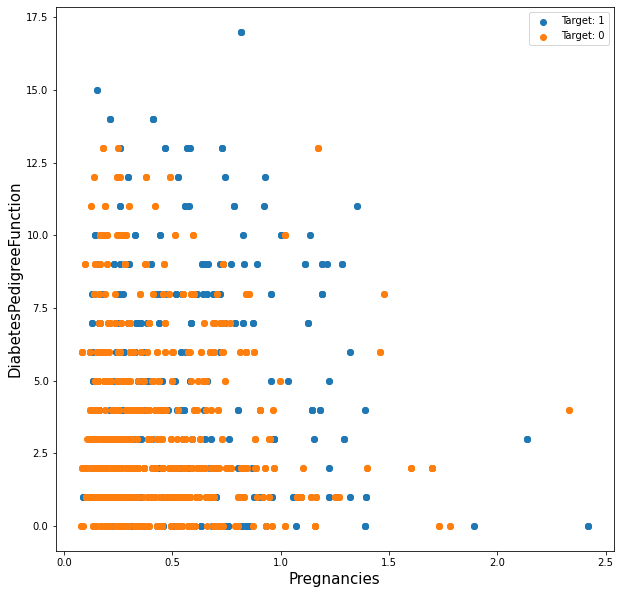

In [224]:
# построим область решений для признаков Glucose и BMI
# данные
diabPedFunc = file['DiabetesPedigreeFunction'].values
pregnancies = file['Pregnancies'].values
outcome = file['Outcome'].values

# создаем два списка с значениями DiabetesPedigreeFunction и Pregnancies для outcome = 1 и для outcome = 0
one = [[], []]
zero = [[], []]
for i, n in enumerate(outcome):
    if n == 1:
        one[0].append(diabPedFunc[i])
        one[1].append(pregnancies[i])
    else:
        zero[0].append(diabPedFunc[i])
        zero[1].append(pregnancies[i])
        
# создаем объект подложки с заданными размерами
plt.figure(figsize=(10, 10))

# подписываем оси
plt.ylabel('DiabetesPedigreeFunction', size=15)
plt.xlabel('Pregnancies', size=15)

# рисуем график для outcome=1
plt.scatter(one[0], one[1], label=f'Target: 1')
plt.legend()

# рисуем график для outcome=0
plt.scatter(zero[0], zero[1], label=f'Target: 0')
plt.legend()

# SVC

C:\Users\Самикаевы\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


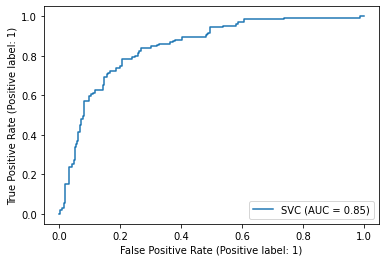

In [210]:
from sklearn.svm import SVC

# задаем гиперпараметры
parameters = {'C':[1, 2], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'max_iter': [50, 100, 150, -1]}

# создаем объект GridSearch
gridSearch_SVC = GridSearchCV(SVC(), parameters, scoring='accuracy')

# отлавливаем предупреждения
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # игнорируем предупреждения
    
    # обучаем модель
    gridSearch_SVC.fit(x_train, y_train)
    
    # извлекаем лучшую модель
    best_SVC = gridSearch_SVC.best_estimator_
    
# ROC-кривая
plot_roc_curve(best_SVC , x_test, y_test)

C:\Users\E394~1\AppData\Local\Temp/ipykernel_4236/860532994.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  roc = np.array(roc)


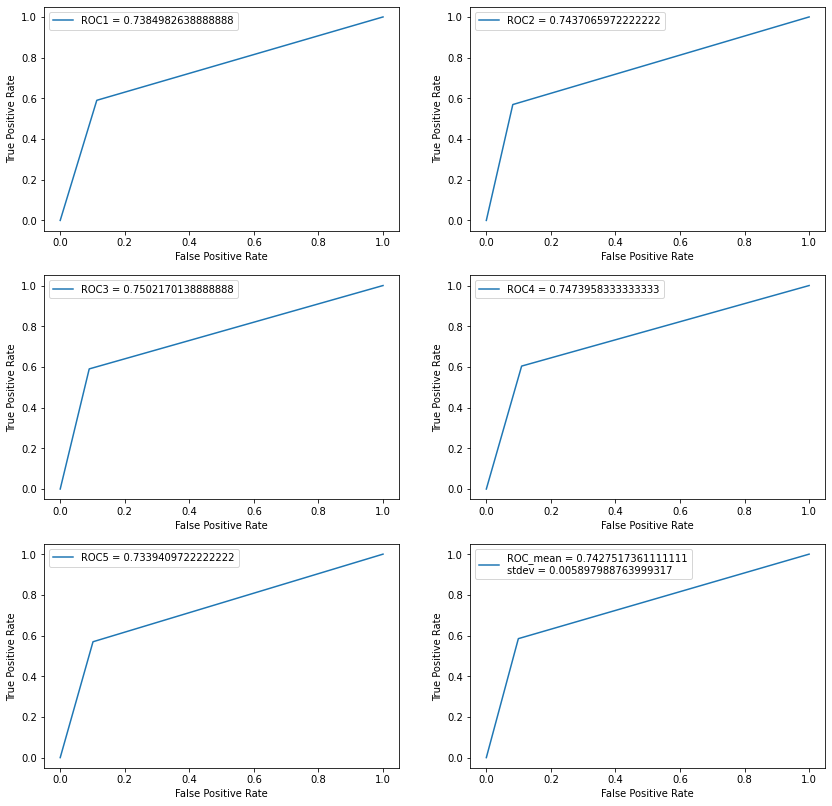

In [212]:
# K-блочная стратифицированная проверка 
from sklearn.model_selection import StratifiedKFold

# разделяем датасет на 5 кросс-сетов
skf = StratifiedKFold(n_splits=5)

roc = []

# данные
X = file.loc[ : , 'Pregnancies':'Age'].values
y = file['Outcome'].values

for train_index, test_index in skf.split(X, y):
    # получаем обучающие и тестовые наборы
    x_tr, y_tr = X[train_index], y[train_index]
    x_ts, y_ts = X[test_index], y[test_index]
    
    # создаем модель на основе наилучших параметров
    svc = SVC(**gridSearch_SVC.best_params_)
    # обучаем модель
    svc.fit(x_tr, y_tr)

    # рассчитываем fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, svc.predict(x_test))
    # рассчитываем площадь под кривой roc
    roc_score = roc_auc_score(y_test, svc.predict(x_test))
    # добавляем все в список
    roc.append([fpr, tpr, roc_score])

roc = np.array(roc)

# создаем объект подложки с заданными размерами
plt.figure(figsize=(14, 14))

# задаем счетик
i = 1
# задаем список всех auc
roc_std = []
for x, y, auc in roc:  # проходимся по всем сетам
    plt.subplot(3, 2, i)
    
    # подпишем оси
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # нарисуем график и создадим легенду
    plt.plot(x, y, label=f'ROC{i} = {auc}')
    plt.legend()
    
    # добавим auc в список
    roc_std.append(auc)
    i += 1

# рассчитаем средние значения
x_mean, y_mean, auc_mean = np.sum(roc, axis=0) / 5

# найдем стандартное отклонение
roc_std = np.std(roc_std)

# построим график roc_mean
plt.subplot(3, 2, i)

# подпишем оси
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# нарисуем график и создадим легенду
plt.plot(x_mean, y_mean, label=f'ROC_mean = {auc_mean}\nstdev = {roc_std}')
plt.legend()

 Результаты: 
 - лучший показатель ROC-кривой оказался у методов RandomForest и XGBoost; 
 - наиболее важными показателями для метода  RandomForest оказались уровень глюкозы в крови и показатель массы тедла человека, что кажется вполне логичным и интерпретируемым; 
 - для логистической регрессии же наиболее важными признаками оказались результаты функции, которая оценивает вероятность развития диабета на основе семейного анамнеза, и количество беременностей.